In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
data = pd.read_csv('/content/cleaned_tweets (3).csv')
data = data.dropna(subset=['final_text', 'airline_sentiment', 'airline'])
data['final_text'] = data['final_text'].astype(str)
data['label'] = data['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})


In [ ]:
negative_tweets = data[data['label'] == 0].copy()


In [ ]:
# Enhanced crisis keywords - more comprehensive
crisis_keywords = {
    'service_issues': ['delay', 'delayed', 'cancel', 'canceled', 'cancelled', 'lost luggage', 'baggage'],
    'severe_complaints': ['disaster', 'emergency', 'horrible', 'terrible', 'worst', 'nightmare', 'disgusting'],
    'operational_problems': ['stranded', 'stuck', 'missed flight', 'overbooked', 'rude staff', 'unprofessional'],
    'safety_concerns': ['unsafe', 'dangerous', 'scared', 'panic', 'emergency landing']
}

In [ ]:
# Flatten keywords
all_keywords = [keyword for category in crisis_keywords.values() for keyword in category]

def enhanced_crisis_detection(tweet):
    """
    More sophisticated crisis detection based on:
    1. Keyword presence and frequency
    2. Intensity of language
    3. Multiple crisis indicators
    """
    tweet_lower = tweet.lower()
    keyword_count = sum(1 for keyword in all_keywords if keyword in tweet_lower)
    # Intensity indicators
    intensity_words = ['never', 'always', 'every time', 'constantly', 'forever', 'absolutely']
    intensity_count = sum(1 for word in intensity_words if word in tweet_lower)
    caps_words = len([word for word in tweet.split() if word.isupper() and len(word) > 2])
    caps_ratio = caps_words / len(tweet.split()) if len(tweet.split()) > 0 else 0

    # Crisis scoring
    crisis_score = 0
    crisis_score += keyword_count * 2  # Main crisis keywords
    crisis_score += intensity_count * 1.5  # Intensity multiplier
    crisis_score += caps_ratio * 3  # Caps indicate strong emotion

    # Additional patterns
    if any(pattern in tweet_lower for pattern in ['never again', 'worst experience', 'never flying']):
        crisis_score += 3

    if re.search(r'\b(hours?|days?)\s+(late|delay)', tweet_lower):
        crisis_score += 2

    # Crisis threshold
    return 1 if crisis_score >= 3 else 0




In [ ]:

# Apply enhanced detection
negative_tweets['is_crisis'] = negative_tweets['final_text'].apply(enhanced_crisis_detection)

print("Enhanced Crisis Detection Results:")
print("Class Distribution:")
print(negative_tweets['is_crisis'].value_counts(normalize=True))
print()


Enhanced Crisis Detection Results:
Class Distribution:
is_crisis
0    0.79124
1    0.20876
Name: proportion, dtype: float64



In [ ]:

# Feature engineering
def extract_features(tweets):
    """Extract additional features beyond TF-IDF"""
    features = pd.DataFrame()

    # Text length features
    features['text_length'] = tweets.str.len()
    features['word_count'] = tweets.str.split().str.len()

    # Emotional indicators
    features['exclamation_count'] = tweets.str.count('!')
    features['question_count'] = tweets.str.count('\?')
    features['caps_ratio'] = tweets.apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

    # Crisis keyword density
    features['crisis_keyword_count'] = tweets.apply(
        lambda x: sum(1 for keyword in all_keywords if keyword in x.lower())
    )
    features['crisis_keyword_density'] = features['crisis_keyword_count'] / features['word_count']

    return features


In [ ]:

# Prepare data for training
X_text = negative_tweets['final_text']
X_features = extract_features(X_text)
y = negative_tweets['is_crisis']


In [ ]:
# Split data
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text, X_features, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:

# TF-IDF Vectorization with better parameters
tfidf = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    ngram_range=(1, 2),  # Include bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

In [ ]:
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine TF-IDF with additional features
from scipy.sparse import hstack
X_train_combined = hstack([X_text_train_tfidf, X_feat_train.values])
X_test_combined = hstack([X_text_test_tfidf, X_feat_test.values])


In [ ]:

# Improved XGBoost model
xgb_model = xgb.XGBClassifier(
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=1  # Handle class imbalance if needed
)


In [ ]:

# Cross-validation
cv_scores = cross_val_score(xgb_model, X_train_combined, y_train, cv=5, scoring='f1')
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Average CV F1 Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train model
xgb_model.fit(X_train_combined, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:31:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:31:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:31:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:31:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:31:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation F1 Scores: [0.96828047 0.94397284 0.96621622 0.95741056 0.97666667]
Average CV F1 Score: 0.963 (+/- 0.022)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:31:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predictions - FIXED THE MISSING LINE
y_pred = xgb_model.predict(X_test_combined)
y_pred_proba = xgb_model.predict_proba(X_test_combined)[:, 1]


In [ ]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Crisis', 'Crisis']))



Accuracy: 0.989

Classification Report:
              precision    recall  f1-score   support

  Non-Crisis       0.99      1.00      0.99      1453
      Crisis       0.99      0.95      0.97       383

    accuracy                           0.99      1836
   macro avg       0.99      0.98      0.98      1836
weighted avg       0.99      0.99      0.99      1836



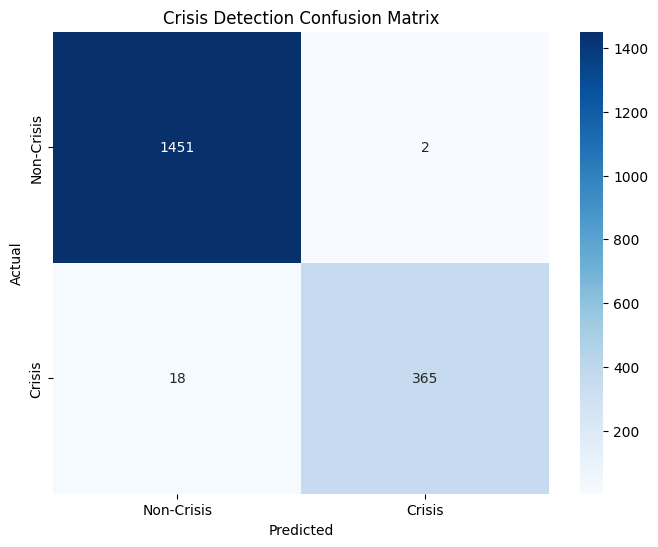

In [ ]:

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Crisis', 'Crisis'],
            yticklabels=['Non-Crisis', 'Crisis'])
plt.title('Crisis Detection Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:

# Crisis analysis by airline
test_indices = X_text_test.index
negative_tweets_test = negative_tweets.loc[test_indices].copy()
negative_tweets_test['predicted_is_crisis'] = y_pred
negative_tweets_test['crisis_probability'] = y_pred_proba


In [ ]:

# Crisis statistics by airline
crisis_by_airline = negative_tweets_test[negative_tweets_test['predicted_is_crisis'] == 1].groupby('airline').size()
total_negative_by_airline = negative_tweets_test.groupby('airline').size()
crisis_ratio = (crisis_by_airline / total_negative_by_airline).fillna(0)


In [ ]:

print("\nCrisis Detection Results by Airline:")
print("="*50)
for airline in crisis_ratio.index:
    total = total_negative_by_airline[airline]
    crisis_count = crisis_by_airline.get(airline, 0)
    ratio = crisis_ratio[airline]
    print(f"{airline}: {crisis_count}/{total} ({ratio:.1%}) crisis tweets")



Crisis Detection Results by Airline:
American: 84/395 (21.3%) crisis tweets
Delta: 28/188 (14.9%) crisis tweets
Southwest: 55/246 (22.4%) crisis tweets
US Airways: 92/467 (19.7%) crisis tweets
United: 103/509 (20.2%) crisis tweets
Virgin America: 5/31 (16.1%) crisis tweets


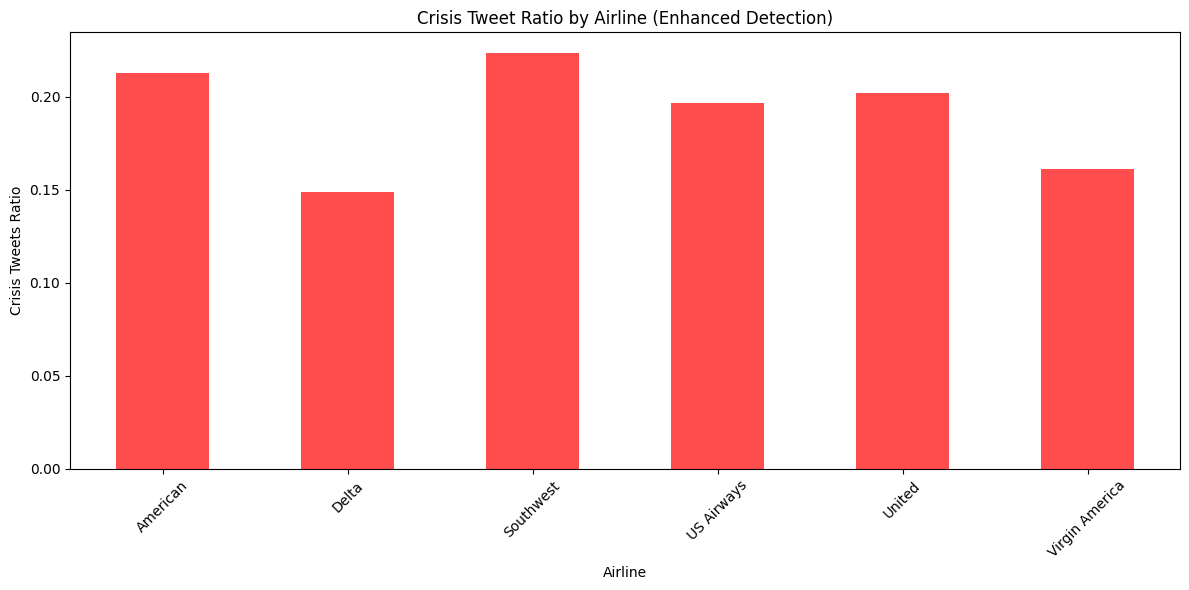

In [ ]:

# Visualization
plt.figure(figsize=(12, 6))
crisis_ratio.plot(kind='bar', color='red', alpha=0.7)
plt.title('Crisis Tweet Ratio by Airline (Enhanced Detection)')
plt.xlabel('Airline')
plt.ylabel('Crisis Tweets Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Sample crisis tweets with confidence scores
print("\nHigh-Confidence Crisis Tweets:")
print("="*50)
high_confidence_crisis = negative_tweets_test[
    (negative_tweets_test['predicted_is_crisis'] == 1) &
    (negative_tweets_test['crisis_probability'] > 0.8)
].sort_values('crisis_probability', ascending=False)

for idx, row in high_confidence_crisis.head(5).iterrows():
    print(f"Airline: {row['airline']}")
    print(f"Confidence: {row['crisis_probability']:.2f}")
    print(f"Tweet: {row['final_text'][:100]}...")
    print("-" * 50)


High-Confidence Crisis Tweets:
Airline: Delta
Confidence: 1.00
Tweet: lost luggage my mom is baggage is lost fly 1557 fort lauderdale bogot today colombian employee treat...
--------------------------------------------------
Airline: US Airways
Confidence: 1.00
Tweet: customer service issue customer service is dead last wk flts delayed cancelled flighted bag lost 4 d...
--------------------------------------------------
Airline: American
Confidence: 1.00
Tweet: cancelled flight cannot provide u alternative flight 36 hour late flightr ruining our trip cancelled...
--------------------------------------------------
Airline: American
Confidence: 1.00
Tweet: cancelled flight cancelled flightled two flight miami nashville yesterday could not get me flight 3 ...
--------------------------------------------------
Airline: United
Confidence: 1.00
Tweet: cancelled flight terrible travel experience traveled 800 mile roundtrip two cancelled flightlations ...
-------------------------------------

In [ ]:

# Feature importance
feature_names = list(tfidf.get_feature_names_out()) + list(X_features.columns)
importance_scores = xgb_model.feature_importances_


In [ ]:

# Get top important features
top_indices = np.argsort(importance_scores)[-20:]
top_features = [feature_names[i] for i in top_indices]
top_scores = importance_scores[top_indices]


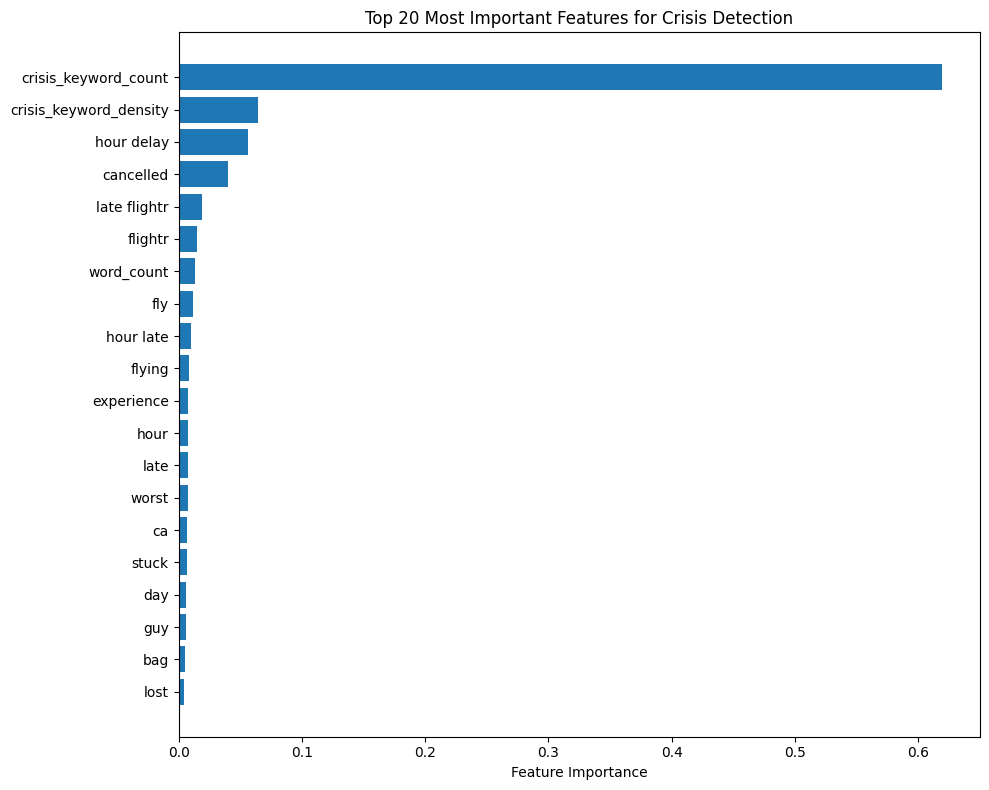

In [ ]:

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_scores)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features for Crisis Detection')
plt.tight_layout()
plt.show()